# Proyecto para evaluar las distintas técnicas de balanceo que comunmente se utilizan

## Importamos librerías y módulos

In [1]:
# Libreria para hacer una SOM 
from minisom import MiniSom 

# Librerias para trabajar con datasets
import numpy as np 
import pandas as pd

# Libreria para hacer gráficas
import matplotlib.pyplot as plt
%matplotlib inline

# Libreria para SOMs del CEIEC, de momento sin usar 
import GEMA

# Libreria con los algoritmos de under sampling y over sampling
from imblearn.under_sampling import *
from imblearn.over_sampling import *

# Antiguas funciones del becario que empezo el proyecto (Javier Caracuel)
from src import workflow as wf

# Nuevas funciones del becario que continua y termina el proyecto (Carlos Arranz)
from src import funcionesCarlos as functions

2022-09-28 12:49:00.615061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 12:49:00.784273: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 12:49:01.335331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-28 12:49:01.335428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

El error que se produce en la representación de GEMA es cosa de la librería pero no impide seguir ejecutando las cosas. TAmbién es posible ver como se ha representado osea que no influye en nada

In [2]:
### ESTE CÓDIGO RECARGA LOS MÓDULOS/LIBRERÍAS CARGADOS ANTES DE CADA EJECUCIÓN PARICAL DEL CÓDIGO, DE TAL FORMA
### QUE PODEMOS CAMBIARUNA FUNCIÓN NUESTRA EN MITAD DE LA EJECUCIÓN Y DICHOS CAMBIOS SE EFECTUARÁN 
### ESTO ES ÚTIL CUANDO AÚN SE ESTÁ EN FASE DE DESARROLLO Y HAY QUE VERIFICAR SI LAS FUNCIONES TIENEN
### EL COMPORTAMIENTO DESEADO

%reload_ext autoreload

%autoreload 2

## Importamos el dataset del oil spill, que contiene datos de distintas imágenes de satélites. En una minoría de las imágenes tendremos un derrame de petróleo, y en la gran mayoría no. Tenemos un problema de clasificación binaria desbalanceado

## Detection of Oil Spills in Satellite Radar Images

In [3]:
## En el libro "Imbalanced Classification with Python" nos proporcionan el dataset en la siguiente URL
## 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv'
## Usaremos ese csv por tanto como nuestro dataframe
DF_oil_spill_bruto = pd.read_csv('DATASETS/oil-spill.csv', header=None)
## Dentro de la carpeta DATASETS se ubican todos los CSV que usaremos

In [4]:
### COMPROBAMOS LA CARGA DEL DATA FRAME
DF_oil_spill_bruto

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500.0,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000.0,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,200,12,92.42,364.42,135,97200.0,59.42,10.34,884.0,0.17,...,381.84,254.56,84.85,146.97,4.50,0,2593.50,65.85,6.39,0
933,201,11,98.82,248.64,159,89100.0,59.64,10.18,831.0,0.17,...,284.60,180.00,150.00,51.96,1.90,0,4361.25,65.70,6.53,0
934,202,14,25.14,428.86,24,113400.0,60.14,17.94,847.0,0.30,...,402.49,180.00,180.00,0.00,2.24,0,2153.05,65.91,6.12,0
935,203,10,96.00,451.30,68,81000.0,59.90,15.01,831.0,0.25,...,402.49,180.00,90.00,73.48,4.47,0,2421.43,65.97,6.32,0


### La última columna (49) nos indica si la imagen contenía un derrame de petróleo (1), o no (0)

In [5]:
# Obtenemos el número total de filas y columnas de nuestro DataFrame
numero_filas = DF_oil_spill_bruto.shape[0]
numero_columnas = DF_oil_spill_bruto.shape[1]

print("\nNumero de filas total de nuestro dataframe: " + str(numero_filas))
lista_columnas=list(DF_oil_spill_bruto.columns)
cont=0

while cont<numero_columnas:  
    # Vamos a hacer un recuento de la cantidad de datos (NaN) vacíos que cotiene cada columna para ver cual no sería relevante
    numero=DF_oil_spill_bruto.iloc[:,cont].isna().sum()
    print("\nNumero de nans en la columna "+str(lista_columnas[cont])+": " + str(numero))
    print("En total un %"+str(round(numero/numero_filas*100,2))+" de filas NO tienen el dato de la columna.")    
    cont+=1


Numero de filas total de nuestro dataframe: 937

Numero de nans en la columna 0: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 1: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 2: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 3: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 4: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 5: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 6: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 7: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 8: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 9: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de 

## Hemos comprobado que en este dataset proporcionado, no tenemos ningún dato faltante

## Vamos a comprobar la disparidad entre los dos tipos de datos de este dataset

In [6]:
# La columna 49 es la que indica el tipo de dato que es, o bien '1', o bien '0'
# Obersvaremos como efectivamente es un dataset binario, con dos clases
DF_oil_spill_bruto[49].value_counts()

0    896
1     41
Name: 49, dtype: int64

## Tenemos 896 items del tipo 0, que indica que no es una mancha de petróleo, por 41 del tipo 1, que indica un derrame de petróleo

## Vamos a quitar ahora las etiquetas de las imágenes del data frame, es decir, quitaremos la última columna, ya que necesitamos los datos sin etiquetar para entrenar el SOM
## También normalizaremos los datos mediante la técnica MinMax

In [7]:

### Quitamos la columna 49, que indica la clase, 0 -> no hay derrame, 1 -> hay derrame
DF_oil_spill_sin_etiqueta = DF_oil_spill_bruto.drop(columns = [49])


## Obtenemos las etiquetas
oil_spill_target = DF_oil_spill_bruto[49].values

### Vamos a normalizar los datos
DF_oil_spill_sin_etiqueta = functions.min_max(DF_oil_spill_sin_etiqueta)

DF_oil_spill_sin_etiqueta


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.000000,0.078693,0.795369,0.167291,0.500000,0.088774,0.319870,0.295893,0.181873,0.236111,...,0.638298,0.238507,0.086957,0.079550,0.077489,0.048675,0.0,0.587669,0.976721,0.222222
1,0.002849,0.689181,0.040816,0.308430,1.000000,0.782405,0.486482,0.015926,0.382532,0.000000,...,0.638298,0.481199,1.000000,1.000000,0.943179,0.007830,0.0,0.932995,0.976393,0.046729
2,0.005698,0.003243,0.765631,0.223027,0.488889,0.003048,0.312378,0.272842,0.016699,0.222222,...,0.638298,0.117161,0.021739,0.015636,0.025816,0.121754,1.0,0.558460,0.979016,0.210800
3,0.008547,0.036783,0.825213,0.108185,0.366667,0.041157,0.344625,0.299246,0.108469,0.236111,...,0.638298,0.505595,0.066224,0.047241,0.082929,0.173953,1.0,0.671567,0.974426,0.234683
4,0.011396,0.009327,0.501465,0.161501,0.205556,0.009961,0.328827,0.259849,0.016761,0.208333,...,0.638298,0.110470,0.061794,0.053426,0.062444,0.033668,0.0,0.508444,0.974098,0.159917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,0.566952,0.000062,0.047854,0.133435,0.750000,0.000377,0.621824,0.398575,0.001356,0.208333,...,0.234043,0.031955,0.022136,0.008845,0.084073,0.058724,0.0,0.010212,0.980328,0.060228
933,0.569801,0.000031,0.051238,0.090925,0.883333,0.000264,0.625407,0.391869,0.001025,0.208333,...,0.234043,0.023817,0.015652,0.015636,0.029723,0.024794,0.0,0.043517,0.975410,0.074766
934,0.572650,0.000124,0.012278,0.157095,0.133333,0.000605,0.633550,0.717100,0.001124,0.388889,...,0.234043,0.033683,0.015652,0.018763,0.000000,0.029231,0.0,0.001913,0.982295,0.032191
935,0.575499,0.000000,0.049747,0.165334,0.377778,0.000150,0.629642,0.594300,0.001025,0.319444,...,0.234043,0.033683,0.015652,0.009381,0.042033,0.058332,0.0,0.006970,0.984262,0.052960


### Vamos a pasar el data frame a numpy array que es el tipo de dato que admite la SOM para entrenarse

In [8]:
# La abreviatura "SE" significa "sin etiquetar"

array_oil_spill_SE=DF_oil_spill_sin_etiqueta.to_numpy()


# Confirmamos que la transformación se ha efectuado correctamente
print("El número de datos del array es "+str(array_oil_spill_SE.shape[0])+ ", con una dimensionalidad de "+str(array_oil_spill_SE.shape[1]))


El número de datos del array es 937, con una dimensionalidad de 49


## Entrenamiento de SOM

### Vamos a realizar un grid search para encontrar los hiperparámetros óptimos

In [9]:
### Estos hiperparámetros son fijos y no van a cambiar en el grid search

n_neurons = 12
m_neurons = 12
dimensionalidad_datos = array_oil_spill_SE.shape[1]
semilla=34

In [10]:
### Como es obligatorio inicializar estas variables, ponemos unos valores por encima del máximo 
### posible para que se sean mejorados en la primera iteración

mejor_error_topologico = 9
mejor_error_cuantificacion = 9

### Variables donde se guardaron losm parametros de la SOM con mejor error topologico y que error ha obtenido
params_ganador_topologico = {'sigma':123,'learning_rate':5.5}
errores_ganador_topologico = {'error_cuantificación':12,'error_topológico':12}

### Variables donde se guardaron losm parametros de la SOM con mejor error de cuantificacion y que error ha obtenido
params_ganador_cuantificacion = {'sigma':123,'learning_rate':5.5}
errores_ganador_cuantificacion = {'error_cuantificación':12,'error_topológico':12}


### Vamos probando para todos los parametros del grid search (están en el archivo 'FuncionesCarlos.py')
for p in functions.params_grid_search_petroleo:
    som = MiniSom(n_neurons, m_neurons, dimensionalidad_datos, sigma=p['sigma'],learning_rate=p['learning_rate'],random_seed=semilla)
    som.train(array_oil_spill_SE, num_iteration=6000, verbose=False)  
    print("--------------------------------------------------------------------------------")
    print("Imprimiendo el error de la red con sigma="+str(p['sigma'])+" y learning rate="+str(p['learning_rate']))
    
    # Obtenemos los errores después de haber entrenado con unos hiperparámetros concretos
    error_topologico=som.topographic_error(array_oil_spill_SE)
    error_cuantificacion=som.quantization_error(array_oil_spill_SE)
    # Imprimimos ese error por pantalla
    print("Error topologico:",str(error_topologico))
    print("Error cuantificacion:"+ str(error_cuantificacion))
    
    # Si el error es mejor que el mejor error topológico existente, guardamos los datos de esta SOM
    if(error_topologico < mejor_error_topologico):
        mejor_error_topologico = error_topologico
        params_ganador_topologico = p
        errores_ganador_topologico['error_cuantificación']=error_cuantificacion
        errores_ganador_topologico['error_topológico']=error_topologico 
    
    # Si el error es mejor que el mejor error de cuantificación existente, guardamos los datos de esta SOM
    if(error_cuantificacion < mejor_error_cuantificacion):
        mejor_error_cuantificacion = error_cuantificacion
        params_ganador_cuantificacion = p
        errores_ganador_cuantificacion['error_cuantificación']=error_cuantificacion
        errores_ganador_cuantificacion['error_topológico']=error_topologico 

print("\n\n--------------------------------------------------------------------------------")
print("-----------------------RESULTADOS-----------------------------------------------")
print("--------------------------------------------------------------------------------")
print("Los hiperparámetros que mejor error de cuantificación han dado son: "+str(params_ganador_cuantificacion))
print("Consiguiendo un error de cuantificación de "+str(mejor_error_cuantificacion))
print("Los errores totales de esta combinación son "+str(errores_ganador_cuantificacion))
print("\n\nLos hiperparámetros que mejor error topológico han dado son: "+str(params_ganador_topologico))
print("Consiguiendo un error topológico de "+str(mejor_error_topologico))
print("Los errores totales de esta combinación son "+str(errores_ganador_topologico))
print("--------------------------------------------------------------------------------\n")

--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=1 y learning rate=0.01
Error topologico: 0.007470651013874066
Error cuantificacion:0.6313766825958819
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=2 y learning rate=0.01
Error topologico: 0.0192102454642476
Error cuantificacion:0.603477881993658
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=3 y learning rate=0.01
Error topologico: 0.016008537886873
Error cuantificacion:0.5938618156808868
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=4 y learning rate=0.01
Error topologico: 0.004268943436499467
Error cuantificacion:0.6063773647439618
--------------------------------------------------------------------------------
Imprimiendo el error de la re

--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=2 y learning rate=0.5
Error topologico: 0.0768409818569904
Error cuantificacion:0.4358045675208936
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=3 y learning rate=0.5
Error topologico: 0.06510138740661686
Error cuantificacion:0.5232255976550131
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=4 y learning rate=0.5
Error topologico: 0.0768409818569904
Error cuantificacion:0.6130509717128
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=5 y learning rate=0.5
Error topologico: 0.13874066168623267
Error cuantificacion:0.8388317490078891
--------------------------------------------------------------------------------
Imprimiendo el error de la red con s

# -------------------------------------------------------------------------------
# PRIMERO PRIORIZANDO ERROR DE CUANTIFICACIÓN
# -------------------------------------------------------------------------------

## Vamos a probar la red con el error de cuantificación más bajo

In [11]:
## Entrenamos la red con los hiperparámetros de la red ganadora en error de cuantificación

som_cuantificacion = MiniSom(n_neurons, m_neurons,  dimensionalidad_datos, sigma=params_ganador_cuantificacion['sigma'],learning_rate=params_ganador_cuantificacion['learning_rate'],random_seed=semilla)

## Entrenamos e imprimimos error
som_cuantificacion.train(array_oil_spill_SE, num_iteration=6000, verbose=True)
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))


 [  840 / 6000 ]  14% - 0:00:00 left 

 [ 1162 / 6000 ]  19% - 0:00:00 left 

 [ 2027 / 6000 ]  34% - 0:00:00 left 

 [ 2354 / 6000 ]  39% - 0:00:00 left 

 [ 3187 / 6000 ]  53% - 0:00:00 left 

 [ 3530 / 6000 ]  59% - 0:00:00 left 

 [ 4379 / 6000 ]  73% - 0:00:00 left 

 [ 4705 / 6000 ]  78% - 0:00:00 left 

 [ 5558 / 6000 ]  93% - 0:00:00 left 

 [ 5879 / 6000 ]  98% - 0:00:00 left 

 [ 6000 / 6000 ] 100% - 0:00:00 left 
 quantization error: 0.35644287514540923
Topological error: 0.23265741728922093


## Mapa de distancias de las neuronas, indicando también qué neurona ha reconocido a cada clase (puede haber una neurona que identifique ítems de ambas clases)

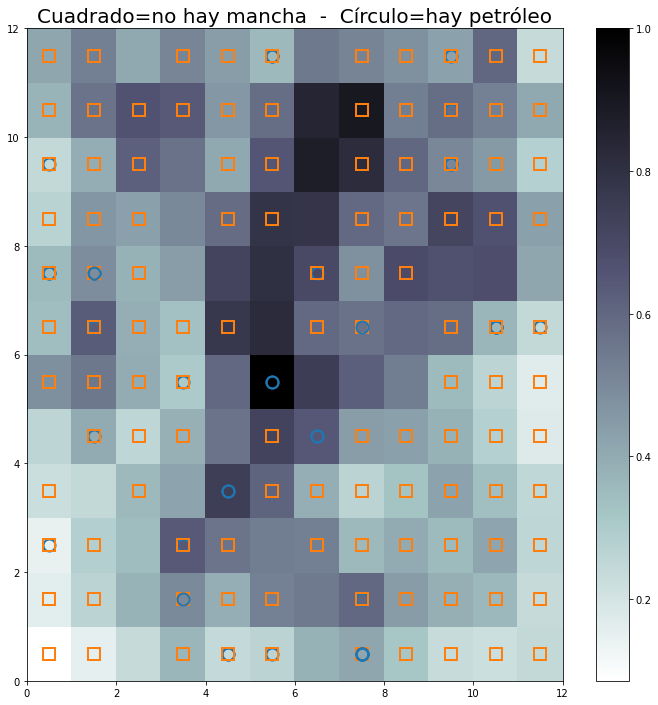

In [12]:
## Vamos a quedarnos con las neuronas donde se ha identificado una imagen del tipo minoritario, para poder 
## posteriormente analizar los datos sintéticos
## Si se ha identificado una imagen del dato minoritario, pondremos TRUE de lo contrario FALSE
## Será por tanto una matriz con el mismo tamanio que la SOM
matriz_activaciones_clase_minoritaria = np.full((n_neurons, m_neurons), False, dtype=bool)

### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar gráficamente este mapa
### de distancias, con el extra para poder hacer la matriz de activaciones de la clase minoritaria

plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}


plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern 
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(array_oil_spill_SE):
    w = som_cuantificacion.winner(xx)  # getting the winner
    
    ##---------------------------------------------------------------
    ## Mi codigo para controlar las neuronas que han reconocido un elemento de la clase minoritaria
    if (oil_spill_target[cnt]== 1): 
        matriz_activaciones_clase_minoritaria[w[0]][w[1]]=True
        #Significa que si es 1 es de la clase minoritaria, por tanto obtenemos la ubicación de la neurona ganadora
        #en la red SOM, y en nuestra matriz que imita a esa red la ponemos a True porque es una neurona que ha
        #reconocido un elemento de la clase minoritaria
    ##---------------------------------------------------------------
    
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[oil_spill_target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[oil_spill_target[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos, donde cada punto es un ítem de nuestro dataset

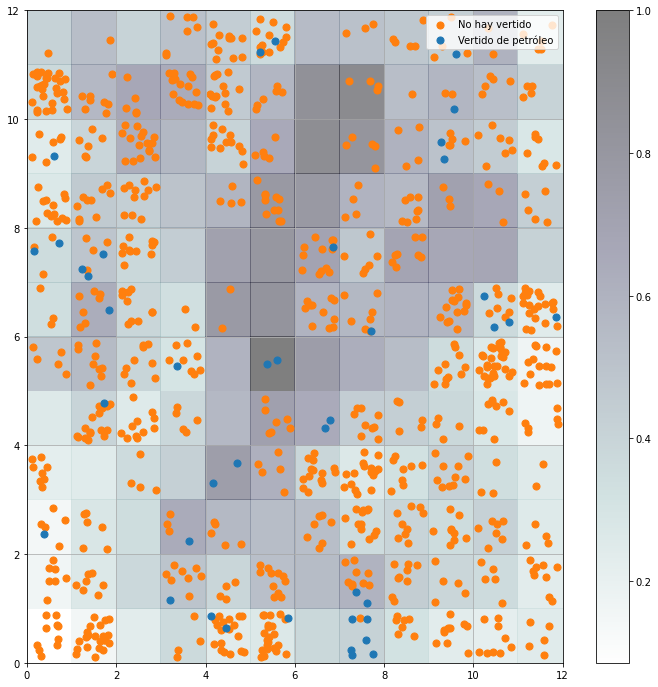

In [13]:
### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de puntos

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_cuantificacion.winner(d) for d in array_oil_spill_SE])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(oil_spill_target):
    idx_target = oil_spill_target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# -------------------------------------------------------------------------------
# SEGUNDO PRIORIZANDO ERROR TOPOLÓGICO
# -------------------------------------------------------------------------------

## Vamos a probar la red con el error topológico más bajo

In [14]:
## Entrenamos la red con los hiperparámetros de la red ganadora en error topológico

som_topologico = MiniSom(n_neurons, m_neurons,  dimensionalidad_datos, sigma=params_ganador_topologico['sigma'],learning_rate=params_ganador_topologico['learning_rate'],random_seed=semilla)

## Entrenamos e imprimimos error
som_topologico.train(array_oil_spill_SE, num_iteration=6000, verbose=True)  # random training
print("Topological error:",som_topologico.topographic_error(array_oil_spill_SE))


 [ 1208 / 6000 ]  20% - 0:00:00 left 

 [ 2402 / 6000 ]  40% - 0:00:00 left 

 [ 3568 / 6000 ]  59% - 0:00:00 left 

 [ 4759 / 6000 ]  79% - 0:00:00 left 

 [ 5950 / 6000 ]  99% - 0:00:00 left 

 [ 6000 / 6000 ] 100% - 0:00:00 left 
 quantization error: 0.6425194705682868
Topological error: 0.0


## Mapa de distancias de las neuronas, indicando también qué neurona ha reconocido a cada clase (puede haber una neurona que identifique ítems de ambas clases)

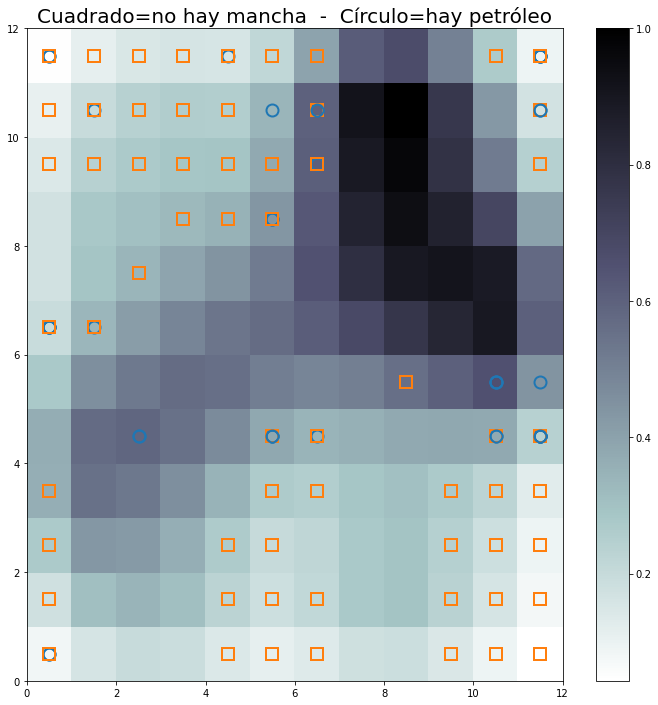

In [15]:
## Como de momento estamos trabajando con la SOM que gana en error de cuantificación, ya que tiene un mejor
## equilibrio, por tanto aquí no vamos a hacer una matriz de activaciones de la clase minoritaria

### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar
### gráficamente este mapa de distancias

plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}


plt.pcolor(som_topologico.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


# Plotting the response for each pattern
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(array_oil_spill_SE):
    w = som_topologico.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[oil_spill_target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[oil_spill_target[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos, donde cada punto es un ítem de nuestro dataset

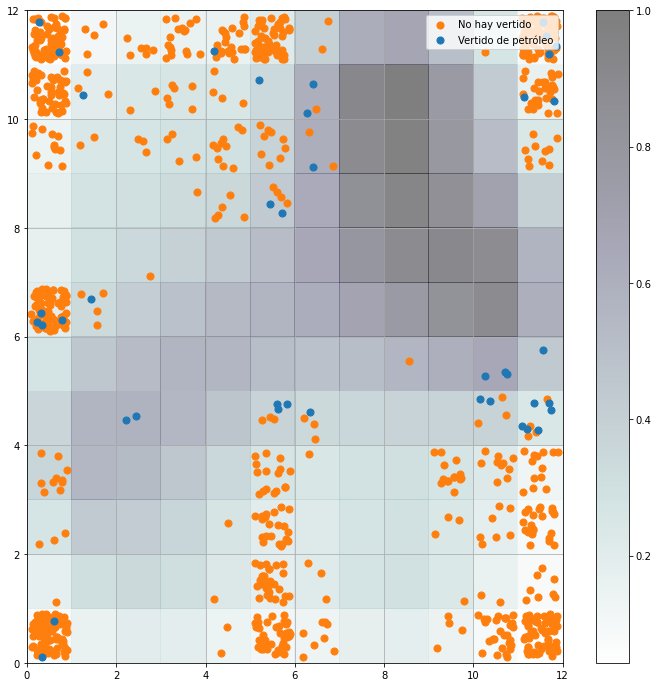

In [16]:
### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de puntos



label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_topologico.winner(d) for d in array_oil_spill_SE])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_topologico.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(oil_spill_target):
    idx_target = oil_spill_target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Generación de datos sintéticos mediante técnicas de undersampling y oversampling

## Vamos a generar datos sintéticos usando la librería "Imbalanced Learn", que nos brinda todos los algoritmos de undersampling y oversampling que necesitaremos. Usaremos ambos métodos combinados para ver con qué combinaciones tenemos mejores resultados

## Usaremos los siguientes algoritmos para realizar oversampling:         
###        ◦ SMOTE
###        ◦ ADASYN
###        ◦ Borderline SMOTE
###        ◦ SVM SMOTE
###        ◦ Kmeans SMOTE

## Usaremos los siguientes algoritmos para realizar undersampling:         
###        ◦ Tomek Links
###        ◦ Edited Nearest Neighbors
###        ◦ Condensed Nearest Neighbors
###        ◦ Neighbourhood Cleaning Rule
###        ◦ One Side Selection

## ------------------------------------------------------------

## SMOTE: combinaciones con undersampling y errores

In [17]:

## Llamamos a una función que nos prueba todas las combinaciones posibles de SMOTE con under sampling

array_X,array_y,SMOTE_elems_sinteticos,SMOTE_etiquetas_sinteticos=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"SMOTE")

## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection


### Vamos a probar el error de los datos
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos
print("\nERROR DE LOS DATOS SINTETICOS(oversampling):")
print("Topological error:",som_cuantificacion.topographic_error(SMOTE_elems_sinteticos))
print("Quantization error:",som_cuantificacion.quantization_error(SMOTE_elems_sinteticos))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos combinados con los originales - undersampling
print("\nERROR DE LOS DATOS SINTETICOS + ORIGINALES con distintos undersamplings aplicados:")
functions.SOM_errores(som_cuantificacion,array_X,"SMOTE")

ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS(oversampling):
Topological error: 0.36374269005847953
Quantization error: 0.4558123325812135

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS + ORIGINALES con distintos undersamplings aplicados:


ERROR de SMOTE y Tomek Links:
Topological error: 0.29520089285714285
Quantization error: 0.40385408391081806


ERROR de SMOTE y Edited Nearest Neighbors:
Topological error: 0.29520089285714285
Quantization error: 0.40385408391081806


ERROR de SMOTE y Condensed Nearest Neighbors:
Topological error: 0.2318840579710145
Quantization error: 0.35174374349287113


ERROR de SMOTE y Neighbourhood Cleaning Rule:
Topological error: 0.29520089285714285
Quantization error: 0.40385408391081806


ERROR de SMOTE y One Side Selection:
Topological error: 0.

## Vamos a analizar los datos sintéticos en mayor profundidad

## Mapa de distancias de las neuronas, en este caso veremos qué neuronas han reconocido los datos sintéticos, y contaremos cuántos datos han sido reconocidos por una neurona que con los datos originales, reconoció algún elemento de la clase minoritaria. Este proceso identificaría el número de "hits" de estos datos sintéticos

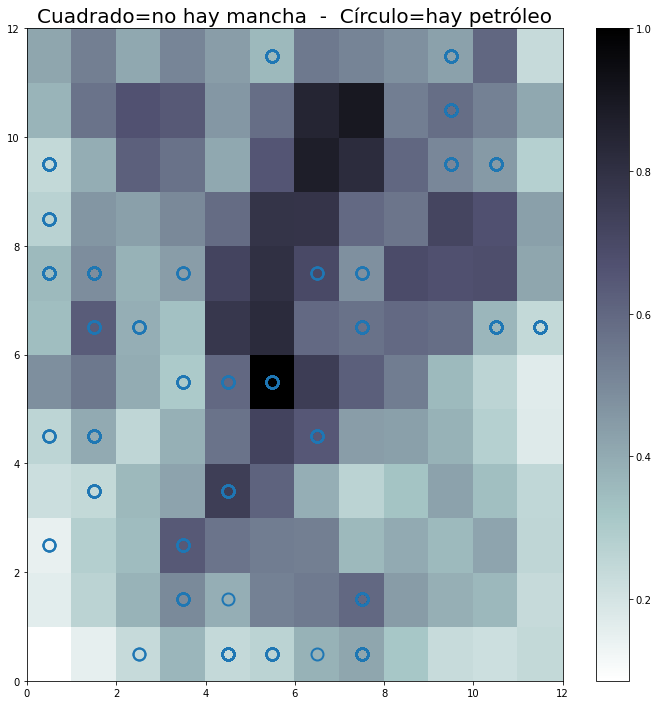

In [18]:
## Contador donde guardaremos el número de "hits"
contador_elementos_sinteticos_buenos = 0

### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de distancias,

plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}


plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


# Plotting the response for each pattern
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(SMOTE_elems_sinteticos):
    w = som_cuantificacion.winner(xx)  # getting the winner
    
    ##---------------------------------------------------------------
    ## Mi codigo para controlar la neurona que ha reconocido al elemento sintetico
    if (matriz_activaciones_clase_minoritaria[w[0]][w[1]]==True): 
        # Si en nuestra matriz de activaciones, esta neurona estaba a "True" significa que en los datos originales
        # había reconocido un elemento de la clase minoritaria, por tanto es un "hit" y sumamos uno al contador
        contador_elementos_sinteticos_buenos+=1
    ##---------------------------------------------------------------
    
    
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[SMOTE_etiquetas_sinteticos[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[SMOTE_etiquetas_sinteticos[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos de los datos sintéticos

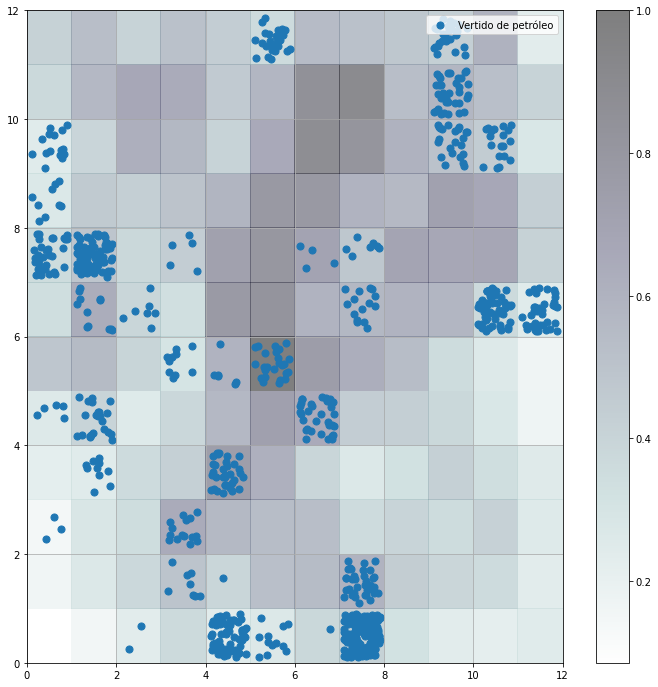

In [19]:
### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de puntos

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_cuantificacion.winner(d) for d in SMOTE_elems_sinteticos])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(SMOTE_etiquetas_sinteticos):
    idx_target = SMOTE_etiquetas_sinteticos==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Vamos a comprobar cuántos "hits" ha habido y qué porcentaje representan

In [20]:
porcentaje_hits = contador_elementos_sinteticos_buenos / SMOTE_etiquetas_sinteticos.shape[0]

print("Número de hits: "+str(contador_elementos_sinteticos_buenos))
print("Número total de elementos sintéticos: "+str(SMOTE_etiquetas_sinteticos.shape[0]))
print("Porcentaje de hits: "+str(porcentaje_hits))

Número de hits: 783
Número total de elementos sintéticos: 855
Porcentaje de hits: 0.9157894736842105


## ------------------------------------------------------------

## ADASYN: combinaciones con undersampling y errores

In [21]:

## Llamamos a una función que nos prueba todas las combinaciones posibles de ADASYN con under sampling

array_X,array_y,ADASYN_elems_sinteticos,ADASYN_etiquetas_sinteticos=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"ADASYN")

## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection



### Vamos a probar el error de los datos
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos
print("\nERROR DE LOS DATOS SINTETICOS(oversampling):")
print("Topological error:",som_cuantificacion.topographic_error(ADASYN_elems_sinteticos))
print("Quantization error:",som_cuantificacion.quantization_error(ADASYN_elems_sinteticos))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos combinados con los originales - undersampling
print("\nERROR DE LOS DATOS SINTETICOS + ORIGINALES con undersampling aplicado:")
functions.SOM_errores(som_cuantificacion,array_X,"ADASYN")



ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS(oversampling):
Topological error: 0.3108265424912689
Quantization error: 0.4480196166599032

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS + ORIGINALES con undersampling aplicado:


ERROR de ADASYN y Tomek Links:
Topological error: 0.2700445434298441
Quantization error: 0.4002426640991678


ERROR de ADASYN y Edited Nearest Neighbors:
Topological error: 0.2700445434298441
Quantization error: 0.40024266409916776


ERROR de ADASYN y Condensed Nearest Neighbors:
Topological error: 0.23647932131495228
Quantization error: 0.3559840952650369


ERROR de ADASYN y Neighbourhood Cleaning Rule:
Topological error: 0.2699771689497717
Quantization error: 0.4003411193054494


ERROR de ADASYN y One Side Selection:
Topological error: 0.2622196664749

## Vamos a analizar los datos sintéticos en mayor profundidad

## Mapa de distancias de las neuronas, en este caso veremos qué neuronas han reconocido los datos sintéticos, y contaremos cuántos datos han sido reconocidos por una neurona que con los datos originales, reconoció algún elemento de la clase minoritaria. Este proceso identificaría el número de "hits" de estos datos sintéticos

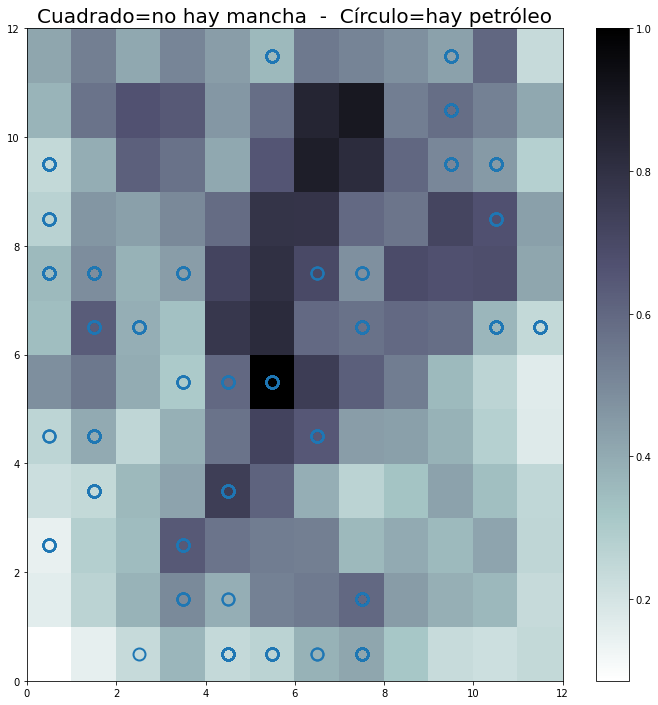

In [22]:
## Contador donde guardaremos el número de "hits"
contador_elementos_sinteticos_buenos = 0

### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de distancias,

plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}


plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


# Plotting the response for each pattern
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(ADASYN_elems_sinteticos):
    w = som_cuantificacion.winner(xx)  # getting the winner
    
    ##---------------------------------------------------------------
    ## Mi codigo para controlar la neurona que ha reconocido al elemento sintetico
    if (matriz_activaciones_clase_minoritaria[w[0]][w[1]]==True): 
        # Si en nuestra matriz de activaciones, esta neurona estaba a "True" significa que en los datos originales
        # había reconocido un elemento de la clase minoritaria, por tanto es un "hit" y sumamos uno al contador
        contador_elementos_sinteticos_buenos+=1
    ##---------------------------------------------------------------
    
    
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[ADASYN_etiquetas_sinteticos[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[ADASYN_etiquetas_sinteticos[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos de los datos sintéticos

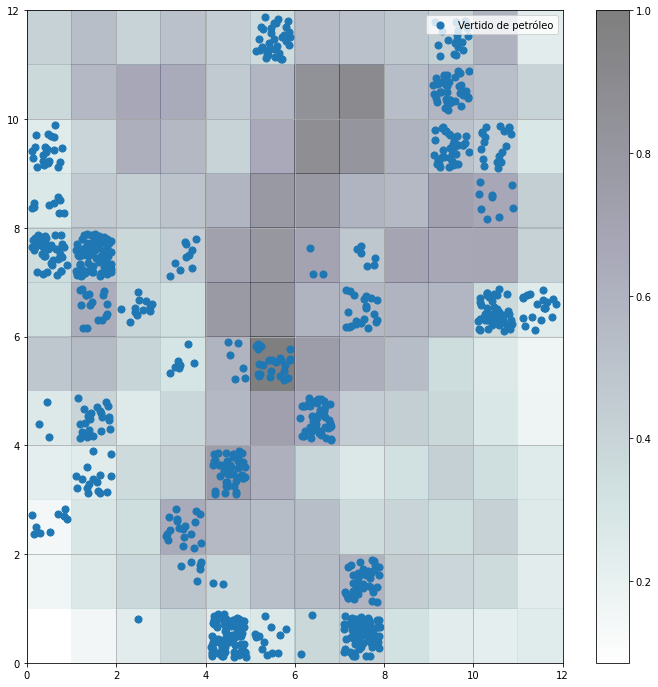

In [23]:
### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de puntos

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_cuantificacion.winner(d) for d in ADASYN_elems_sinteticos])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(ADASYN_etiquetas_sinteticos):
    idx_target = ADASYN_etiquetas_sinteticos==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Vamos a comprobar cuántos "hits" ha habido y qué porcentaje representan

In [24]:
porcentaje_hits = contador_elementos_sinteticos_buenos / ADASYN_etiquetas_sinteticos.shape[0]

print("Número de hits: "+str(contador_elementos_sinteticos_buenos))
print("Número total de elementos sintéticos: "+str(ADASYN_etiquetas_sinteticos.shape[0]))
print("Porcentaje de hits: "+str(porcentaje_hits))

Número de hits: 764
Número total de elementos sintéticos: 859
Porcentaje de hits: 0.889406286379511


## ------------------------------------------------------------

## Borderline SMOTE: combinaciones con undersampling y errores

In [25]:
## Llamamos a una función que nos prueba todas las combinaciones posibles de Borderline SMOTE con under sampling

array_X,array_y,BorderlineSMOTE_elems_sinteticos,BorderlineSMOTE_etiquetas_sinteticos=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"BorderlineSMOTE")
## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection



### Vamos a probar el error de los datos
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos
print("\nERROR DE LOS DATOS SINTETICOS(oversampling):")
print("Topological error:",som_cuantificacion.topographic_error(BorderlineSMOTE_elems_sinteticos))
print("Quantization error:",som_cuantificacion.quantization_error(BorderlineSMOTE_elems_sinteticos))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos combinados con los originales - undersampling
print("\nERROR DE LOS DATOS SINTETICOS + ORIGINALES con undersampling aplicado:")
functions.SOM_errores(som_cuantificacion,array_X,"BorderlineSMOTE")



ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS(oversampling):
Topological error: 0.4105263157894737
Quantization error: 0.47403045680823513

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS + ORIGINALES con undersampling aplicado:


ERROR de BorderlineSMOTE y Tomek Links:
Topological error: 0.3176996091568956
Quantization error: 0.41257027280381436


ERROR de BorderlineSMOTE y Edited Nearest Neighbors:
Topological error: 0.3180291153415454
Quantization error: 0.41258657744542926


ERROR de BorderlineSMOTE y Condensed Nearest Neighbors:
Topological error: 0.2329988851727982
Quantization error: 0.3519364133099557


ERROR de BorderlineSMOTE y Neighbourhood Cleaning Rule:
Topological error: 0.31787709497206706
Quantization error: 0.41259410095691373


ERROR de BorderlineSMOTE y One Si

## Vamos a analizar los datos sintéticos en mayor profundidad

## Mapa de distancias de las neuronas, en este caso veremos qué neuronas han reconocido los datos sintéticos, y contaremos cuántos datos han sido reconocidos por una neurona que con los datos originales, reconoció algún elemento de la clase minoritaria. Este proceso identificaría el número de "hits" de estos datos sintéticos

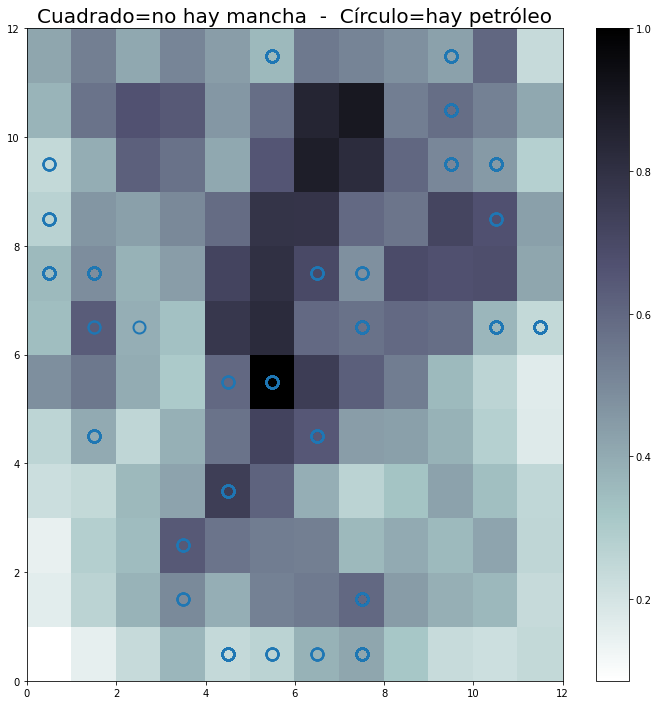

In [26]:
## Contador donde guardaremos el número de "hits"
contador_elementos_sinteticos_buenos = 0

### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de distancias,

plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}


plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


# Plotting the response for each pattern
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(BorderlineSMOTE_elems_sinteticos):
    w = som_cuantificacion.winner(xx)  # getting the winner
    
    ##---------------------------------------------------------------
    ## Mi codigo para controlar la neurona que ha reconocido al elemento sintetico
    if (matriz_activaciones_clase_minoritaria[w[0]][w[1]]==True): 
        # Si en nuestra matriz de activaciones, esta neurona estaba a "True" significa que en los datos originales
        # había reconocido un elemento de la clase minoritaria, por tanto es un "hit" y sumamos uno al contador
        contador_elementos_sinteticos_buenos+=1
    ##---------------------------------------------------------------
    
    
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[BorderlineSMOTE_etiquetas_sinteticos[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[BorderlineSMOTE_etiquetas_sinteticos[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos de los datos sintéticos

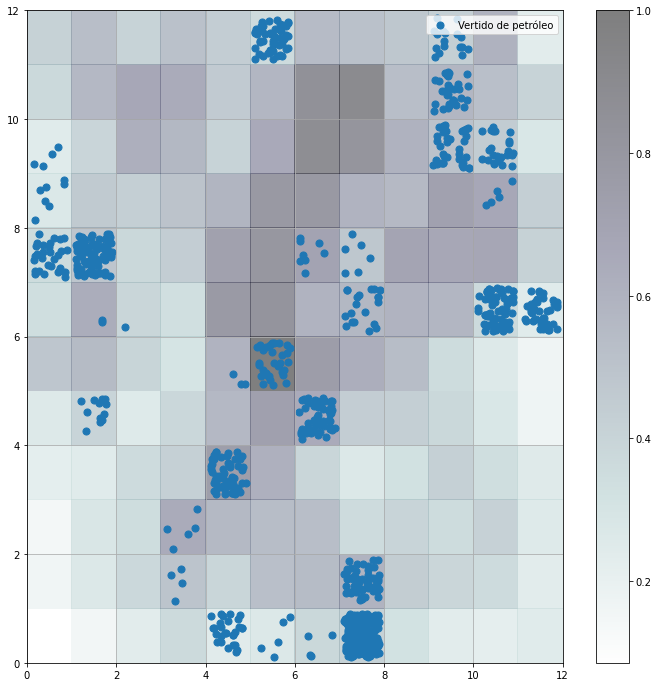

In [27]:
### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de puntos

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_cuantificacion.winner(d) for d in BorderlineSMOTE_elems_sinteticos])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(BorderlineSMOTE_etiquetas_sinteticos):
    idx_target = BorderlineSMOTE_etiquetas_sinteticos==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Vamos a comprobar cuántos "hits" ha habido y qué porcentaje representan

In [28]:
porcentaje_hits = contador_elementos_sinteticos_buenos / BorderlineSMOTE_etiquetas_sinteticos.shape[0]

print("Número de hits: "+str(contador_elementos_sinteticos_buenos))
print("Número total de elementos sintéticos: "+str(BorderlineSMOTE_etiquetas_sinteticos.shape[0]))
print("Porcentaje de hits: "+str(porcentaje_hits))

Número de hits: 805
Número total de elementos sintéticos: 855
Porcentaje de hits: 0.9415204678362573


## ------------------------------------------------------------

## SVM SMOTE: combinaciones con undersampling y errores

In [29]:
## Llamamos a una función que nos prueba todas las combinaciones posibles de SVM SMOTE con under sampling

array_X,array_y,SVMSMOTE_elems_sinteticos,SVMSMOTE_etiquetas_sinteticos=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"SVMSMOTE")
## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection



### Vamos a probar el error de los datos
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos
print("\nERROR DE LOS DATOS SINTETICOS(oversampling):")
print("Topological error:",som_cuantificacion.topographic_error(SVMSMOTE_elems_sinteticos))
print("Quantization error:",som_cuantificacion.quantization_error(SVMSMOTE_elems_sinteticos))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos combinados con los originales - undersampling
print("\nERROR DE LOS DATOS SINTETICOS + ORIGINALES con undersampling aplicado:")
functions.SOM_errores(som_cuantificacion,array_X,"SVMSMOTE")



ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS(oversampling):
Topological error: 0.5497076023391813
Quantization error: 0.48433186096951486

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS + ORIGINALES con undersampling aplicado:


ERROR de SVMSMOTE y Tomek Links:
Topological error: 0.384142936906756
Quantization error: 0.41748802855919914


ERROR de SVMSMOTE y Edited Nearest Neighbors:
Topological error: 0.38517686692869174
Quantization error: 0.41780825244598907


ERROR de SVMSMOTE y Condensed Nearest Neighbors:
Topological error: 0.2318840579710145
Quantization error: 0.35180817726888863


ERROR de SVMSMOTE y Neighbourhood Cleaning Rule:
Topological error: 0.3840134153158189
Quantization error: 0.4175364659692476


ERROR de SVMSMOTE y One Side Selection:
Topological error: 0.2

## Vamos a analizar los datos sintéticos en mayor profundidad

## Mapa de distancias de las neuronas, en este caso veremos qué neuronas han reconocido los datos sintéticos, y contaremos cuántos datos han sido reconocidos por una neurona que con los datos originales, reconoció algún elemento de la clase minoritaria. Este proceso identificaría el número de "hits" de estos datos sintéticos

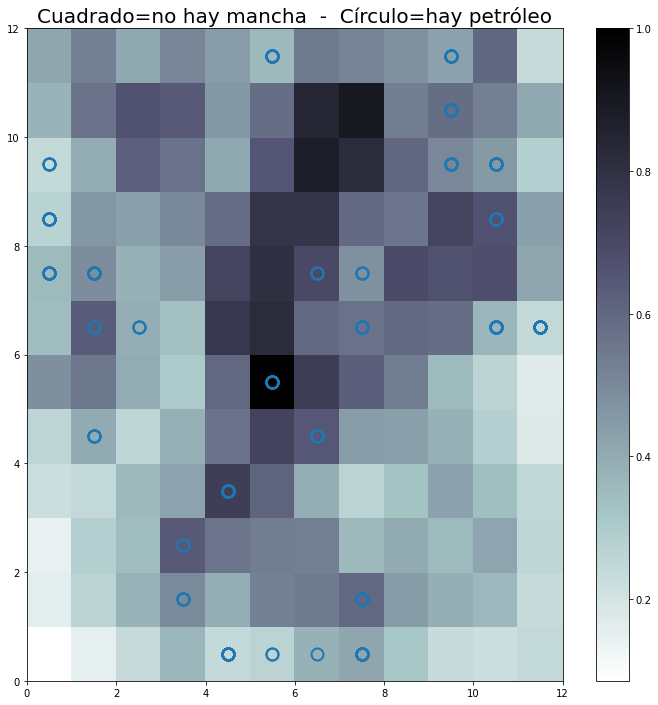

In [30]:
## Contador donde guardaremos el número de "hits"
contador_elementos_sinteticos_buenos = 0

### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de distancias,

plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}


plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


# Plotting the response for each pattern
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(SVMSMOTE_elems_sinteticos):
    w = som_cuantificacion.winner(xx)  # getting the winner
    
    ##---------------------------------------------------------------
    ## Mi codigo para controlar la neurona que ha reconocido al elemento sintetico
    if (matriz_activaciones_clase_minoritaria[w[0]][w[1]]==True): 
        # Si en nuestra matriz de activaciones, esta neurona estaba a "True" significa que en los datos originales
        # había reconocido un elemento de la clase minoritaria, por tanto es un "hit" y sumamos uno al contador
        contador_elementos_sinteticos_buenos+=1
    ##---------------------------------------------------------------
    
    
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[SVMSMOTE_etiquetas_sinteticos[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[SVMSMOTE_etiquetas_sinteticos[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos de los datos sintéticos

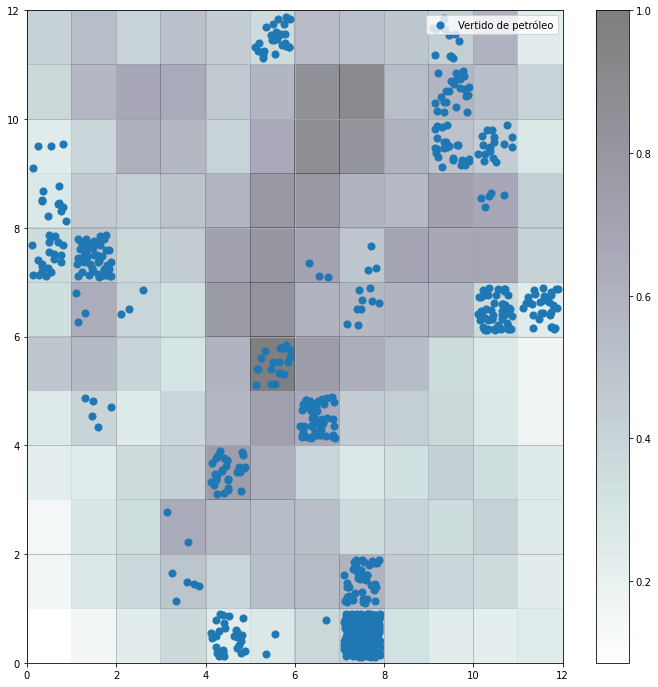

In [31]:
### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de puntos

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_cuantificacion.winner(d) for d in SVMSMOTE_elems_sinteticos])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(SVMSMOTE_etiquetas_sinteticos):
    idx_target = SVMSMOTE_etiquetas_sinteticos==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Vamos a comprobar cuántos "hits" ha habido y qué porcentaje representan

In [32]:
porcentaje_hits = contador_elementos_sinteticos_buenos / SVMSMOTE_etiquetas_sinteticos.shape[0]

print("Número de hits: "+str(contador_elementos_sinteticos_buenos))
print("Número total de elementos sintéticos: "+str(SVMSMOTE_etiquetas_sinteticos.shape[0]))
print("Porcentaje de hits: "+str(porcentaje_hits))

Número de hits: 815
Número total de elementos sintéticos: 855
Porcentaje de hits: 0.9532163742690059


## ------------------------------------------------------------

## KMeans SMOTE: combinaciones con undersampling y errores

In [33]:
## Llamamos a una función que nos prueba todas las combinaciones posibles de KMeans SMOTE con under sampling

array_X,array_y,KMeansSMOTE_elems_sinteticos,KMeansSMOTE_etiquetas_sinteticos=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"KMeansSMOTE")
## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection



### Vamos a probar el error de los datos
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos
print("\nERROR DE LOS DATOS SINTETICOS(oversampling):")
print("Topological error:",som_cuantificacion.topographic_error(KMeansSMOTE_elems_sinteticos))
print("Quantization error:",som_cuantificacion.quantization_error(KMeansSMOTE_elems_sinteticos))
print("\n-----------------------------------------------------------------")

#Vamos a imprimir el error solo de los datos sintéticos combinados con los originales - undersampling
print("\nERROR DE LOS DATOS SINTETICOS + ORIGINALES con undersampling aplicado:")
functions.SOM_errores(som_cuantificacion,array_X,"KMeansSMOTE")




ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS(oversampling):
Topological error: 0.2091121495327103
Quantization error: 0.4188266320558735

-----------------------------------------------------------------

ERROR DE LOS DATOS SINTETICOS + ORIGINALES con undersampling aplicado:


ERROR de KMeansSMOTE y Tomek Links:
Topological error: 0.2216638749302066
Quantization error: 0.3862663371988028


ERROR de KMeansSMOTE y Edited Nearest Neighbors:
Topological error: 0.22053872053872053
Quantization error: 0.3855638378012783


ERROR de KMeansSMOTE y Condensed Nearest Neighbors:
Topological error: 0.23076923076923078
Quantization error: 0.35595464078381966


ERROR de KMeansSMOTE y Neighbourhood Cleaning Rule:
Topological error: 0.22330097087378642
Quantization error: 0.3863292806094461


ERROR de KMeansSMOTE y One Side Selection:
Topolog

## Vamos a analizar los datos sintéticos en mayor profundidad

## Mapa de distancias de las neuronas, en este caso veremos qué neuronas han reconocido los datos sintéticos, y contaremos cuántos datos han sido reconocidos por una neurona que con los datos originales, reconoció algún elemento de la clase minoritaria. Este proceso identificaría el número de "hits" de estos datos sintéticos

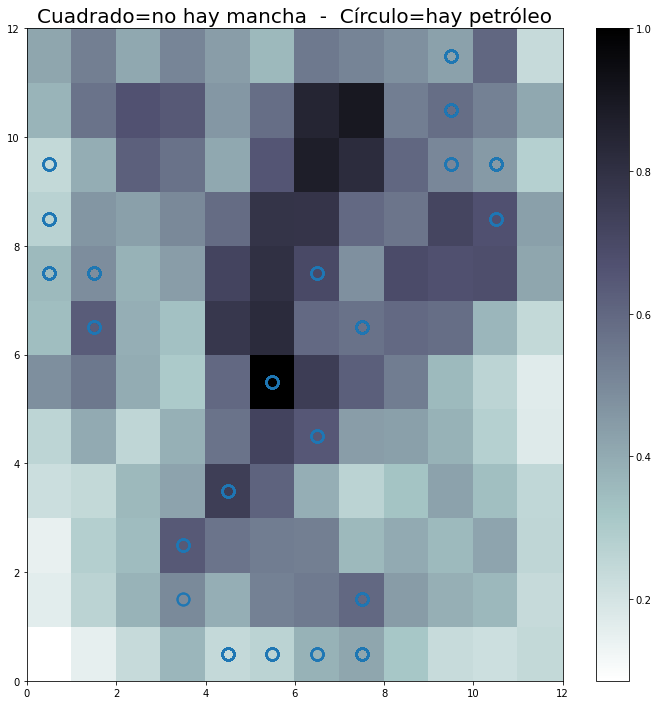

In [34]:
## Contador donde guardaremos el número de "hits"
contador_elementos_sinteticos_buenos = 0

### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de distancias,

plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}


plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


# Plotting the response for each pattern
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(KMeansSMOTE_elems_sinteticos):
    w = som_cuantificacion.winner(xx)  # getting the winner
    
    ##---------------------------------------------------------------
    ## Mi codigo para controlar la neurona que ha reconocido al elemento sintetico
    if (matriz_activaciones_clase_minoritaria[w[0]][w[1]]==True): 
        # Si en nuestra matriz de activaciones, esta neurona estaba a "True" significa que en los datos originales
        # había reconocido un elemento de la clase minoritaria, por tanto es un "hit" y sumamos uno al contador
        contador_elementos_sinteticos_buenos+=1
    ##---------------------------------------------------------------
    
    
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[KMeansSMOTE_etiquetas_sinteticos[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[KMeansSMOTE_etiquetas_sinteticos[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos de los datos sintéticos

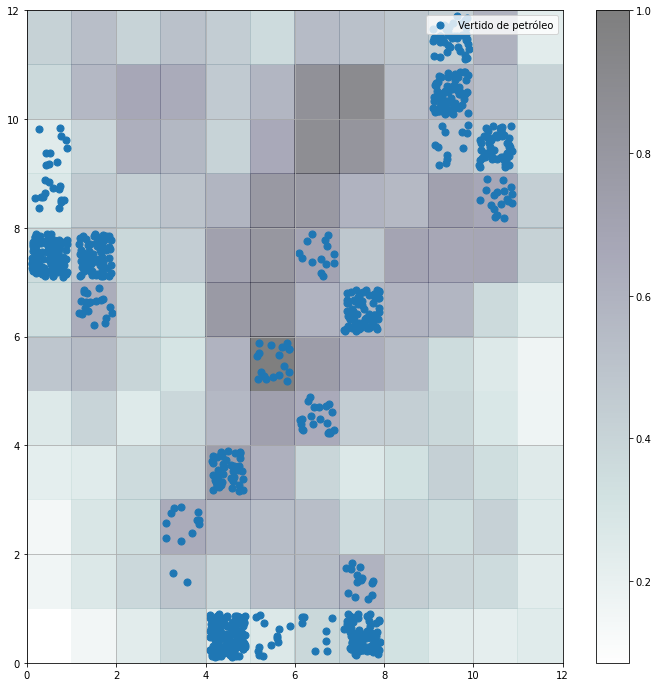

In [35]:
### A continuación está el código extraído de ejemplos del Github de MiniSOM, donde se explica como representar 
### gráficamente este mapa de puntos

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_cuantificacion.winner(d) for d in KMeansSMOTE_elems_sinteticos])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(KMeansSMOTE_etiquetas_sinteticos):
    idx_target = KMeansSMOTE_etiquetas_sinteticos==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Vamos a comprobar cuántos "hits" ha habido y qué porcentaje representan

In [36]:
porcentaje_hits = contador_elementos_sinteticos_buenos / KMeansSMOTE_etiquetas_sinteticos.shape[0]

print("Número de hits: "+str(contador_elementos_sinteticos_buenos))
print("Número total de elementos sintéticos: "+str(KMeansSMOTE_etiquetas_sinteticos.shape[0]))
print("Porcentaje de hits: "+str(porcentaje_hits))

Número de hits: 764
Número total de elementos sintéticos: 856
Porcentaje de hits: 0.8925233644859814
